### 4 Objects Classification

In [19]:
# importing libraries
import math
import tensorflow as tf
import keras
from keras.layers import *
import numpy as np
import random
import io
import os
from sklearn.model_selection import train_test_split
from keras.activations import tanh, softmax, sigmoid
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import tensorflow as tf
import random
import os
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import (
    LSTM,
    LSTMCell,
    Input,
    Dense,
    concatenate,
    TimeDistributed,
    Flatten,
    Dropout,
    Masking,
    RepeatVector,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Reshape,
    multiply,
    Permute,
    Concatenate,
    Conv2D,
    Add,
    Activation,
    Lambda,
    BatchNormalization
)
from keras import backend as K, Model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score

In [20]:
# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

if gpus:
    try:
        # Select the first GPU (index 0)
        tf.config.set_visible_devices(gpus[5], 'GPU')

        # Optionally, limit GPU memory growth (prevents TensorFlow from consuming all GPU memory)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print("Using GPU:", gpus[5])
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]
Using GPU: PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU')


In [21]:
# hard objects
plate = np.asarray([1, 0, 0, 0])
# soft objects
phone_cover = np.asarray([0, 1, 0, 0])
bottle = np.asarray([0, 0, 1, 0])
soft_rubber = np.asarray([0, 0, 0, 1])

In [22]:
encoded_objects = [plate, phone_cover, bottle, soft_rubber]

In [23]:
encoded_objects

[array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 0, 1])]

In [24]:
# reading a numpy file
data_dir = './train_val_data'
samples_per_window = 30

def read_npy_files(directory):
  data = []
  labels = []
  i = 0
  for filename in os.listdir(directory):
    if filename.endswith(".npy"):
      base_name = os.path.splitext(filename)[0]
      data.append(np.load(os.path.join(directory, filename), allow_pickle = True))
      # for labelling objects = ['plate', 'ball', 'cover', 'bottle', 'soft_rubber']
      if 'plate' in filename :
          labels.append(np.tile(encoded_objects[0], (samples_per_window, 1)))
      elif 'phone' in filename and 'cover' in filename :
          labels.append(np.tile(encoded_objects[1], (samples_per_window, 1)))
      elif 'bottle' in filename :
          labels.append(np.tile(encoded_objects[2], (samples_per_window, 1)))
      elif 'rubber' in filename :
          labels.append(np.tile(encoded_objects[3], (samples_per_window, 1)))
  return data, labels

all_data, labels = read_npy_files(data_dir)

# converting to numpy array
all_data = np.asarray(all_data)[:, :, :, 1:].astype(np.float32)
labels = np.asarray(labels).astype(np.float32)

In [25]:
all_data.shape

(12, 8, 30, 3)

In [26]:
labels.shape

(12, 30, 4)

Spitting of the train and val dataset

In [27]:
train_all_data = []
val_all_data = []
test_all_data =[]
train_labels = []
val_labels = []
test_labels = []
total_samples = 8
val_samples = 1
test_samples = 1
train_samples = total_samples - val_samples - test_samples


for data in all_data:
  for i in range(train_samples):
    train_all_data.append(data[i])
  for i in range(val_samples):
    val_all_data.append(data[train_samples + i])
  for i in range(test_samples):
    test_all_data.append(data[train_samples + val_samples + i])

for label in labels:
  # label = np.expand_dims(label[1, :], axis = 0)
  # print(np.asarray(label).shape)
  for i in range(train_samples):
    train_labels.append(label[1, :])
  for i in range(val_samples):
    val_labels.append(label[1, :])
  for i in range(test_samples):
    test_labels.append(label[1, :])

In [28]:
# hyperpaprametres
TIME_STEPS = 30
input_dim  = 3
output_dim = 4

In [29]:
class CNN_GRU_Model(tf.keras.Model):
    def __init__(self):
        super(CNN_GRU_Model, self).__init__()

        # 1D Convolutional layers (CNN part)
        self.conv1 = Conv1D(32, kernel_size=3, strides=1, activation='relu')
        self.conv2 = Conv1D(64, kernel_size=3, strides=2, activation='relu')
        self.conv3 = Conv1D(128, kernel_size=3, strides=5, activation='relu')

        # Batch Normalization layers
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

        # Max Pooling layer
        self.max_pool = MaxPooling1D(pool_size=2, strides=2)

        # GRU layer
        self.gru = GRU(1024)

        # Fully connected layer
        self.fc = Dense(4, activation='softmax')  # Output layer for 4-class classification

    def call(self, inputs):
        x_cnn, x_gru = inputs

        # CNN forward pass on (30, 3) input
        x_cnn = self.conv1(x_cnn)
        x_cnn = self.conv2(x_cnn)
        x_cnn = self.bn1(x_cnn)
        x_cnn = self.max_pool(x_cnn)
        x_cnn = self.conv3(x_cnn)
        x_cnn = self.bn2(x_cnn)
        x_cnn = Flatten()(x_cnn)

        # GRU forward pass on (30, 3) input
        x_gru = self.gru(x_gru)

        # Concatenate CNN and GRU outputs
        x = Concatenate()([x_cnn, x_gru])

        # Fully connected layer
        x = self.fc(x)

        return x
    
    def generate(self):
        # Input for CNN (time series data with shape (30, 3))
        cnn_input = Input(shape=(30, 3), name='cnn_input')

        # Input for GRU (time series data with shape (30, 3))
        gru_input = Input(shape=(30, 3), name='gru_input')

        # Call the model's main forward pass (call method) with the inputs
        output = self.call([cnn_input, gru_input])

        # Create a Keras Model instance
        model = Model(inputs=[cnn_input, gru_input], outputs=output)

        return model


In [30]:
cnn_gru = CNN_GRU_Model()
model = cnn_gru.generate()

In [31]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 28, 32)    │        320 │ cnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 13, 64)    │      6,208 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 64)    │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 6, 64)     │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1, 128)    │     24,704 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 128)    │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_input           │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 1024)      │  3,161,088 │ gru_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1152)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      4,612 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,197,700 (12.20 MB)

 Trainable params: 3,197,316 (12.20 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/2000


2024-10-25 12:08:24.905599: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729838305.473618 2610480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838305.522286 2610480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838305.522729 2610480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838305.523126 2610480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838305.523520 2610480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838305.525467 2610480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838305.525926 2610480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838305.560939 2610480 gpu_t

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2500 - f1_score: 0.1856 - loss: 1.6956 - precision_2: 0.3600 - recall_2: 0.1250

W0000 00:00:1729838308.438692 2610479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838308.439195 2610479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838308.439666 2610479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838309.746001 2610479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838309.751280 2610479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838309.755050 2610479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838309.755997 2610479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838309.756841 2610479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729838309.757877 2610479 gp


Epoch 1: val_f1_score improved from -inf to 0.25000, saving model to checkpoint_4obj_model_cnn_gru.keras

Epoch 1: Learning Rate = 0.0010000000474974513
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.2500 - f1_score: 0.1856 - loss: 1.6956 - precision_2: 0.3600 - recall_2: 0.1250 - val_accuracy: 0.2500 - val_f1_score: 0.2500 - val_loss: 8.0927 - val_precision_2: 0.2500 - val_recall_2: 0.2500
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2778 - f1_score: 0.2778 - loss: 8.0353 - precision_2: 0.2778 - recall_2: 0.2778
Epoch 2: val_f1_score did not improve from 0.25000

Epoch 2: Learning Rate = 0.0010000000474974513
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2778 - f1_score: 0.2778 - loss: 8.0353 - precision_2: 0.2778 - recall_2: 0.2778 - val_accuracy: 0.2500 - val_f1_score: 0.2500 - val_loss: 5.2020 - val_precision_2: 0.2500 - val_recall_2: 0.2500
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2778 - f1_score: 0.2778 - loss: 4.9233 - precisio

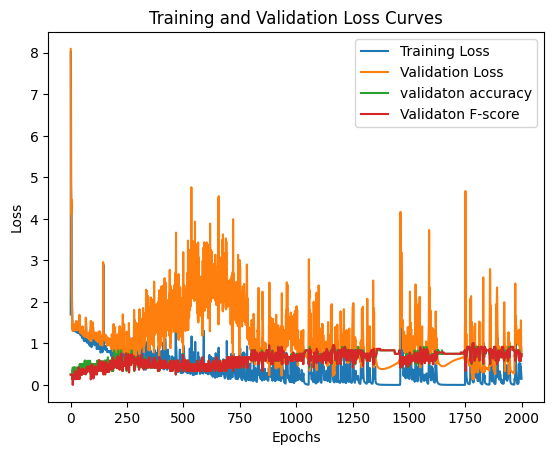

In [32]:
checkpoint_filepath = 'checkpoint_4obj_model_cnn_gru.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_f1_score',
    mode = 'max',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False)

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1 = 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))
    return f1

# Early stopping criteria
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)

initial_lr = 1e-3
decay_rate = 0.5
# val_acc_list = np.asarray(history.history['val_accuracy'])
# max_val_acc = (val_acc_list).max()
# print(max_val_acc, np.where(val_acc_list == max_val_acc)[0] + 1)
optimizer = keras.optimizers.Adam(learning_rate = initial_lr)

model.compile( loss = 'categorical_crossentropy', metrics = ['accuracy', precision, recall, f1_score])

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data
    def on_epoch_end(self, epoch, logs = None):
        lr = self.model.optimizer.learning_rate
        print(f"\nEpoch {epoch + 1}: Learning Rate = {lr.numpy()}")

class ReduceLROnPlateau(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        # Decrease learning rate by 0.1 after each epoch
        lr = float(K.get_value(optimizer.learning_rate))
        if lr > 3.4e-44:
            lr = lr * 0.1
        K.set_value(optimizer.learning_rate, lr)
        print(f"\nEpoch {epoch + 1}: New Learning Rate = {lr}")

# converting the numpy arrays into tensor
train_data_tf = tf.convert_to_tensor(train_all_data)
train_labels_tf = tf.convert_to_tensor(train_labels)
val_data_tf = tf.convert_to_tensor(val_all_data)
val_labels_tf = tf.convert_to_tensor(val_labels)
validation_data = ([val_data_tf, val_data_tf], [val_labels_tf, val_labels_tf])

# training and validating step
history = model.fit([train_data_tf, train_data_tf], [train_labels_tf, train_labels_tf], epochs = 2000, batch_size = 128,
          validation_data = validation_data, callbacks = [model_checkpoint_callback, MetricsCallback(validation_data)])

# for tracking the maximum validation accuracy ata particular epoch
# val_acc_list = np.asarray(history.history['val_accuracy'])
# max_val_acc = (val_acc_list).max()
# print(max_val_acc, np.where(val_acc_list == max_val_acc)[0] + 1)

# plotting the graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='validaton accuracy')
plt.plot(history.history['val_f1_score'], label='Validaton F-score')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()